In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator

In this Jupyter Notebook, we demonstrate the method of using interpolated proper orthogonal decomposition
to create a reduced order model that generates velocity seismograms. We first 
read in the data for the sixteen receivers stored as a numpy binary file.
Due to the file size limits in GitHub, we will make the complete, high-resolution set of seismograms
available in a Zenodo repository upon acceptance of the paper.

In [2]:
velocity_data = np.load('seismos_16_receivers.npy')
print(velocity_data.shape)

(16, 600, 500)


The data are velocity seismograms with units of m/s, sampled at 10 Hz and for 60 second lengths,
for 500 different earthquake source locations. We can plot the seismogram
for the first receiver, first source location, and first
wavefield component (east component), for example, as follows:

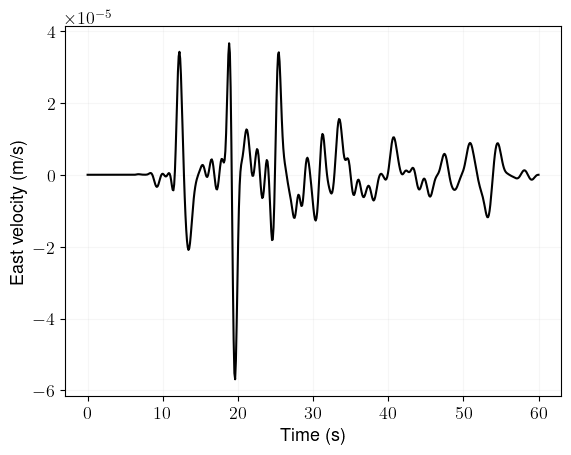

In [3]:
t = np.linspace(0, 60, 600)
plt.plot(t, velocity_data[0, :, 0], c='k')
plt.xlabel('Time (s)')
plt.ylabel('East velocity (m/s)')
plt.show()

We store the source locations in a CSV file and read them as follows:

In [17]:
locations = np.genfromtxt('source_locations.csv', skip_header=1, delimiter=',')
print(locations)

[[ 3535.128805  9935.226342 12551.79364 ]
 [23535.1288    3713.004119 18951.79364 ]
 [13535.1288    8379.670786 15751.79364 ]
 ...
 [24199.1913    8917.393694 13775.47364 ]
 [14199.1913   13584.06036   6095.473638]
 [34199.1913    1830.973941  9295.473638]]


These numbers are the $\Delta \ell, \Delta w,$ and $\Delta z$ values, with units of meters. 
We then take the singular value decomposition of the stacked data matrix,

In [11]:
vel_data_stacked = velocity_data.reshape(-1, 500)
u, s, vh = np.linalg.svd(vel_data_stacked, full_matrices=False)

which gives us the $\bm{U}$, $\bm{\Sigma}$, and $\bm{V}$ matrices. We calculate $\bm{A}$ using

In [12]:
a = vel_data_stacked.T @ u

We then create the RBF interpolator object, withholding the first source location
to use for leave-one-out cross-validation. We use the cubic kernel here
for demonstration.  

In [13]:
rbf = RBFInterpolator(locations[1:], a[1:], kernel='cubic')

We then use the RBF to get the predictions of the POD coefficients,
and then reconstruct the velocity seismograms for the first source location.

In [14]:
apred = rbf(locations[0].reshape(1, -1))
ypred = (u @ apred.T).reshape(16, 600)

We can then compare how well the FOM (black) and ROM (red) seismograms match each other.

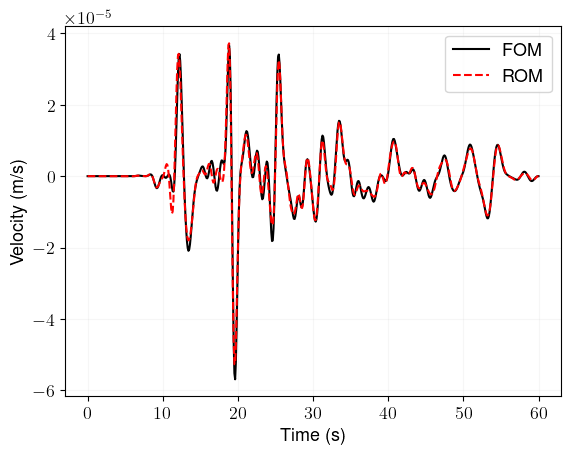

In [16]:
plt.plot(t, velocity_data[0, :, 0], c='k', label='FOM')
plt.plot(t, ypred[0], c='r', ls='--', label='ROM')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.show()